In [1]:
import simulation_settings as ss
import ship_lqr as ship
import constants
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
import glob
import driver
import time
import datetime
from tqdm.notebook import tqdm, trange


In [2]:
gg = constants.gg
rho = constants.rho
beta = constants.beta
dt = constants.dt

In [3]:
drift_calc  = []
drift_exp   = []
period      = []

In [4]:
#reset variables
if('ww' in globals()):del ww
if('pp' in globals()):del pp
if('dd' in globals()):del dd

In [5]:
scale = 3.11/25

In [6]:
#create environment JONSWAP(num_waves, T_1, H_third)
T_1 = 2.8
H_3 = 0.3
# ww = ss.JONSWAP(100,T_1,H_3)
ww = ss.Water(H_3, 2*math.pi/T_1)
print(T_1/math.sqrt(scale))
print(H_3/scale)

7.938671679732397
2.4115755627009645


In [7]:
####################################
# Max Speed -> 3.5m/s (10m/s @ real scale)
# Target Low Speed -> 0.35m/s(simulation scale; 1m/s @ real scale)
# Refer to scaling.ipynb
####################################
start_time = time.perf_counter()

 
power=['engine','motor']
props=['fpp','cpp']

f=0.2
P=3*f
I=1*f
D=1*f

# P=0
# I=0
# D=0

power_type = power[0]
prop_type = props[1]

IMU_en = True

pp = ship.Ship_lqr(0,0.19,P,I,D,power_type,prop_type,IMU_en)

t=0.0
num = 1*10*1000
# num = 5000

dl = []
xl = []
xvl = []
xvl_int = []
xal = []
zl = [] 
zvl= []
zal =[]
eng = []
pl = []
pvl=[]
IMU_ax = []
IMU_az = []
IMU_ry = []
prop_pitch=[]
t_prop_pitch=[]
wil = []
fl = []

PID_vel_err=[]
PID_acc_err=[]
PID_err=[]

PID_curr=[]
PID_targ=[]
PID_star=[]


fps = 50
limit = round(round(1./dt)/fps)

filename = f'T{T_1}_H{H_3}_{power_type},{prop_type}_PID{P},{I},{D}_IMU={IMU_en}'
# with open(f'{filename}.csv', 'a') as the_file:
#         the_file.write('time,posx,posz,velx,velz,accx,accz,pitch,draught,force\n')

fileList = glob.glob('./output/*.png')
for filePath in fileList:
    try:
        os.remove(filePath)
    except:
        print("Error while deleting file : ", filePath)

filenamecount = 0
velx_int = 0

for i in trange(num):
    pp.update(ww,t)

    err = 0.01
    bias = 0.001*dt
    velx_int += (pp.IMU_accx*(random.uniform(1-err,1+err) + bias))*dt
    
    dl.append(pp.draught)
    xl.append(pp.posx)
    xvl.append(pp.velx)
    xal.append(pp.accx)
    zl.append(pp.posz)
    zvl.append(pp.velz)
    zal.append(pp.accz)
    wil.append(pp.wave_incline)
    pl.append(pp.angle*(180/math.pi))
    pvl.append(pp.anglevel*(180/math.pi))
    # fl.append(force)
    IMU_ax.append(pp.IMU_accx)
    IMU_az.append(pp.IMU_accz)
    IMU_ry.append(pp.IMU_roty)
    prop_pitch.append(pp.prop_angle)
    t_prop_pitch.append(pp.target_angle)
    xvl_int.append(velx_int)
    PID_acc_err.append(pp.P_acc_err)
    PID_vel_err.append(pp.P_vel_err)
    PID_err.append(pp.P_err)
    PID_curr.append(pp.P_current_val)
    PID_star.append(pp.P_start_val)
    PID_targ.append(pp.P_target_val)
    fl.append(pp.thr_f)

    # with open(filename, 'a') as the_file:
    #     the_file.write(f'{t},{pp.posx}, {pp.posz}, {pp.velx}, {pp.velz}, {pp.accx}, {pp.accz}, {pp.angle}, {pp.draught}, {force}\n')


    #graph
    # if(i%limit==0):
    #     xdata = np.arange(-4,8,0.05)
    #     ydata = np.array([ww.get(x,t) for x in xdata])
    #     fig, ax = plt.subplots()
    #     ax.set_xlim(-4.0,8.0)
    #     ax.set_ylim(-1,1)
    #     ax.plot(xdata,ydata)
    #     ax.scatter(pp.posx,pp.posz,s=10)
        
    #     ts = ax.transData
    #     coords = ts.transform([pp.posx,pp.posz])
    #     tr = mpl.transforms.Affine2D().rotate_around(coords[0], coords[1], pp.angle)
    #     tt = ts + tr
    #     rec0 = patches.Rectangle((pp.posx-pp.pl/2,pp.posz-pp.ph),pp.pl,pp.ph,linewidth=1,edgecolor='r',facecolor='none', transform=tt)
    #     ax.add_patch(rec0)
        
    #     ax.arrow(pp.posx,pp.posz,pp.posx+pp.accx/10,pp.posz+pp.accz/10)

    #     ax.text(-1.5,0.6,f"Velx = {pp.velx:.2f}[m/s]")
    #     ax.text(-1.5,-0.6,f"{force:.2f}")

    #     ax.set_aspect('equal', adjustable='box')

    #     ax.set_title("Wave Profile T_1 =" + str(T_1) + "[s], H_1/3 =" + str(H_3) + "[m], t=" + str(round(t)) + "[s]")
    #     fig.savefig("./output/"+f"{filenamecount:04d}.png")
    #     plt.clf()
    #     plt.close()
    #     filenamecount += 1
    t+=dt
    


# os.system(f'ffmpeg -y -r {fps} -f image2 -i ./output/%04d.png -vcodec libx264 -pix_fmt yuv420p ./video/PID_T{T_1}_H{H_3}_F{force}_V{target_vel}.mp4')
# os.system("ffmpeg -y -r 50 -f image2 -i ./output/%04d.png -vcodec libx264 -pix_fmt yuv420p ./video/test.mp4")
end_time = time.perf_counter()

print(end_time-start_time)

HBox(children=(FloatProgress(value=0.0, max=10000.0), HTML(value='')))

1972
0.020372908793033363
0.02052430506096671
0.020675776065632066
0.020827320386195655
0.020978936589169748
0.021130623228513293
0.021282378845733304
0.021434201969986983
0.021586091118184568
0.021738044795092892
0.02189006149343965
0.02204213969401833
0.02219427786579386
0.022346474466008858
0.022498727940290602
0.02265103672275857
0.022803399236132657
0.02295581389184197
0.02310827909013425
0.02326079322018585
0.023413354660212327
0.02356596177757956
0.023718612928915445
0.023871306460222112
0.024024040706988683
0.024176813994304533
0.024329624636973055
0.02448247093962592
0.024635351196837817
0.024788263693241636
0.02494120670364414
0.025094178493142053
0.025247177317238596
0.025400201421960412
0.025553249043974945
0.02570631841070816
0.02585940774046269
0.026012515242536317
0.026165639117340857
0.026318777556521348
0.026471928743075607
0.02662509085147409
0.026778262047780083
0.026931440489770184
0.027084624327055083
0.027237811701200623
0.027391000745849114
0.027544189586840927
0

In [8]:
pp.velx

0.03684809973684853

In [9]:
hsl = []
for i, val in enumerate(xvl):
    hsl.append(val*fl[i])

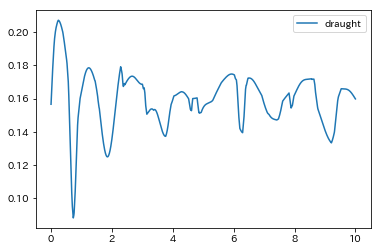

In [10]:
fig, ax = plt.subplots()
tdata = np.arange(0,num*dt,dt)
# ax.set_ylim(-0.5,0.5)
# ax.plot(tdata,xl,label="pos")
# ax.plot(tdata,zvl,label="vel")
# ax.plot(tdata,zal,label="acc")
ax.plot(tdata,dl,label="draught")
# ax.plot(tdata,eng,label="energy")
# ax.plot(tdata,pl,label="pitch angle")
# ax.plot(xl,zl)

# ax.plot(tdata,xvl,label="vel")

ax.legend()

No handles with labels found to put in legend.
0.051877951292819836 0.0008510094777689038
6096.04859264653


Text(0.5,1,'accz')

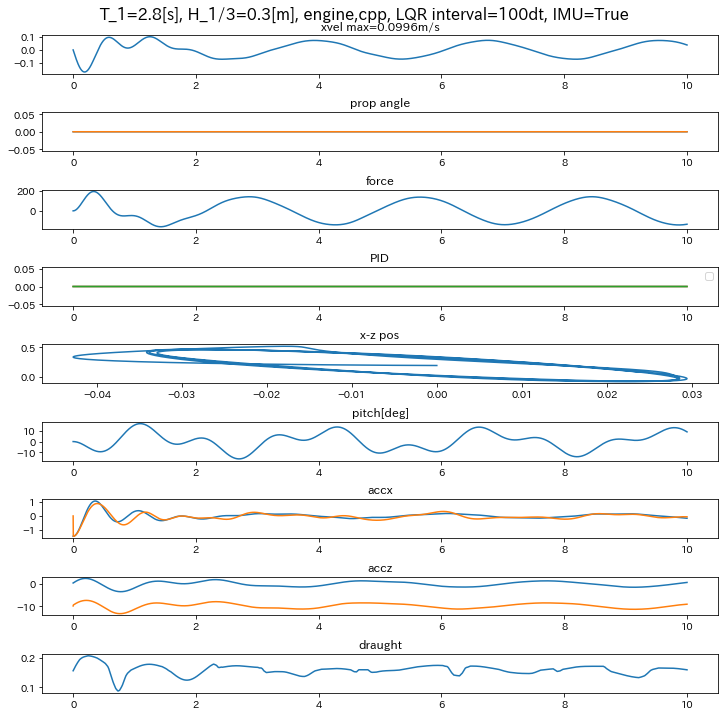

In [11]:
import statistics
xvl_trunc = xvl[-round(len(xvl)/2):]
stdev = statistics.stdev(xvl_trunc)
mean = statistics.mean(xvl_trunc)
cv = stdev/mean*100
print(stdev,mean)
print(cv)

fig, (ax_xvel, ax_rev, ax_thr, ax_PID, ax_pos, ax_pitch, ax_accx, ax_accz, ax_draught) = plt.subplots(nrows=9,figsize=(10,10),constrained_layout=True)

fig.suptitle( f'T_1={T_1}[s], H_1/3={H_3}[m], {power_type},{prop_type}, LQR interval=100dt, IMU={IMU_en}' , fontsize=16)
fig.set_facecolor('white')
ax_xvel.plot(tdata,xvl)
# ax_xvel.plot(tdata,xvl_int)
ax_xvel.set_title(f'xvel max={max(xvl):.4f}m/s')
# ax_xvel.text(1,0.15, f'P Coeff:{P_coeff}')
# ax_xvel.text(1,0.1,f'Coeff of Variance:{cv:.04f}%')

ax_rev.plot(tdata,prop_pitch)
ax_rev.plot(tdata,t_prop_pitch)
ax_rev.set_title('prop angle')

ax_thr.plot(tdata,fl)
# ax_thr.plot(tdata,hsl)
ax_thr.set_title('force')

# ax_PID.plot(tdata,PID_err,label = 'total err')
# ax_PID.plot(tdata,PID_vel_err,label = 'vel err')
# ax_PID.plot(tdata,PID_acc_err,label = 'acc err')
ax_PID.legend()
ax_PID.plot(tdata,PID_curr)
ax_PID.plot(tdata,PID_star)
ax_PID.plot(tdata,PID_targ)
ax_PID.set_title('PID')

ax_draught.plot(tdata,dl)
ax_draught.set_title('draught')

ax_pos.plot(xl,zl)
ax_pos.set_title('x-z pos')

ax_pitch.plot(tdata,pl)
# ax_pitch.plot(tdata,wil)
ax_pitch.set_title('pitch[deg]')

ax_accx.plot(tdata,xal)
ax_accx.plot(tdata,IMU_ax)
ax_accx.set_title('accx')

ax_accz.plot(tdata,zal)
ax_accz.plot(tdata,IMU_az)
ax_accz.set_title('accz')

# fig.savefig("./figures/"+f"LQR lpf 100dt -{time.time()}.png")

In [21]:
import numpy
import scipy
import cvxpy

AttributeError: module 'cvxpy' has no attribute 'lin_ops'